# Logistic Regression on basic numerical data

# Relevant Imports

In [1]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



# Load and preprocess data

In [2]:
# Load the dataset
file_path = '../../../dataset_final/Daily_Financial_News/MS/MS_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


         Date   Open  Close   High      Volume
0  2020-06-10  50.02  48.68  50.50  14770900.0
1  2020-06-09  48.72  50.40  50.68  15090400.0
2  2020-06-08  50.52  50.15  50.68  12150300.0
3  2020-06-05  51.29  49.52  51.84  17976100.0
4  2020-06-04  46.70  48.68  48.75  15279600.0


In [3]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Date      0
Open      0
Close     0
High      0
Volume    0
dtype: int64
              Open        Close         High        Volume
count  2616.000000  2616.000000  2616.000000  2.616000e+03
mean     33.474377    33.464159    33.855528  1.469979e+07
std      11.196241    11.193994    11.263909  8.823711e+06
min      11.890000    12.350000    12.690000  2.087800e+06
25%      25.450000    25.457500    25.847500  8.894650e+06
50%      31.910000    31.930000    32.270000  1.219500e+07
75%      42.840000    42.815000    43.250000  1.770142e+07
max      59.220000    58.900000    59.380000  7.659440e+07


In [4]:
# Drop the current index and reset to default integer index
data = data.reset_index(drop=True)

# Sort the DataFrame by the 'Dates' column in ascending order
data = data.sort_values(by='Date', ascending=True)

data.head()

,Date,Open,Close,High,Volume
2615,2010-01-20,30.76,30.62,31.23,21198800.0
2614,2010-01-21,30.29,29.34,30.54,56774400.0
2613,2010-01-22,28.64,27.79,29.18,46713700.0
2612,2010-01-25,28.21,27.73,28.52,21100900.0
2611,2010-01-26,27.68,27.32,28.29,24376400.0


# Define features and target value

In [5]:
# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day
data['Movement'] = data['Movement'].shift(1)

# Drop the last row because there's no next day to compare
data = data.dropna(subset=['Movement'])

# Convert Movement into binary (1 for up if Movement > 0, else 0)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print(data['Movement'].value_counts().sort_index())

Movement
0    1253
1    1362
Name: count, dtype: int64


In [6]:
# Calculate daily returns (in percentage)
data['Daily_Return'] = data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data = data.dropna(subset=['Volatility'])

In [7]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [8]:
data.tail(20)


,Date,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
19,2020-05-13,38.15,36.99,38.27,11565900.0,0,-3.696954,3.675339,38.41,40.06,13605600.0,-3.565152,3.288440
18,2020-05-14,36.25,37.81,37.97,14986600.0,0,2.216815,3.210941,36.99,38.27,11565900.0,-3.696954,3.675339
17,2020-05-15,37.25,37.29,37.81,9175800.0,0,-1.375298,2.431461,37.81,37.97,14986600.0,2.216815,3.210941
16,2020-05-18,38.91,40.27,40.65,14722400.0,1,7.991419,4.913063,37.29,37.81,9175800.0,-1.375298,2.431461
15,2020-05-19,40.09,39.33,40.54,8895500.0,0,-2.334244,4.696134,40.27,40.65,14722400.0,7.991419,4.913063
14,2020-05-20,40.06,41.06,41.25,12031600.0,1,4.398678,4.234236,39.33,40.54,8895500.0,-2.334244,4.696134
13,2020-05-21,40.77,40.29,40.93,9654200.0,0,-1.875304,4.604502,41.06,41.25,12031600.0,4.398678,4.234236
12,2020-05-22,40.22,40.13,40.54,6468900.0,0,-0.397121,4.478224,40.29,40.93,9654200.0,-1.875304,4.604502
11,2020-05-26,41.86,43.68,43.79,19709900.0,1,8.846250,4.790714,40.13,40.54,6468900.0,-0.397121,4.478224
10,2020-05-27,45.77,46.86,46.91,25892400.0,1,7.280220,4.681031,43.68,43.79,19709900.0,8.846250,4.790714


In [9]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [10]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                 0.016776
Close_lag1          -0.007429
High_lag1           -0.006663
Volume_lag1         -0.015748
Daily_Return_lag1   -0.041428
Volatility_lag1     -0.017306
Name: Movement, dtype: float64


In [11]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


       Open  Close_lag1  High_lag1  Volume_lag1  Daily_Return_lag1  \
2608  27.82       27.48      28.25   25480700.0          -1.681574   
2607  26.95       26.78      27.85   21166100.0          -2.547307   
2606  27.60       27.55      28.00   19559900.0           2.875280   
2605  28.15       28.05      28.20   20992500.0           1.814882   
2604  27.61       27.88      28.43   18498800.0          -0.606061   

      Volatility_lag1  
2608         2.748412  
2607         1.887446  
2606         2.501603  
2605         2.483122  
2604         2.304377  
2608    1
2607    1
2606    1
2605    1
2604    0
Name: Movement, dtype: int64


# Splitting and scaling the data

In [12]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2010-01-29', '2010-02-01', '2010-02-02', '2010-02-03',
               '2010-02-04', '2010-02-05', '2010-02-08', '2010-02-09',
               '2010-02-10', '2010-02-11',
               ...
               '2020-05-28', '2020-05-29', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-08',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='Date', length=2609, freq=None)


In [13]:
X.index = data.index
print(X.index)

DatetimeIndex(['2010-01-29', '2010-02-01', '2010-02-02', '2010-02-03',
               '2010-02-04', '2010-02-05', '2010-02-08', '2010-02-09',
               '2010-02-10', '2010-02-11',
               ...
               '2020-05-28', '2020-05-29', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-08',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='Date', length=2609, freq=None)


In [14]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]
    
    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)
    
    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2010-01-29 to 2011-10-24
Test Dates: 2011-10-25 to 2013-07-18
--------------------------------------------------
Fold 2:
Train Dates: 2010-01-29 to 2013-07-18
Test Dates: 2013-07-19 to 2015-04-09
--------------------------------------------------
Fold 3:
Train Dates: 2010-01-29 to 2015-04-09
Test Dates: 2015-04-10 to 2016-12-27
--------------------------------------------------
Fold 4:
Train Dates: 2010-01-29 to 2016-12-27
Test Dates: 2016-12-28 to 2018-09-18
--------------------------------------------------
Fold 5:
Train Dates: 2010-01-29 to 2018-09-18
Test Dates: 2018-09-19 to 2020-06-10
--------------------------------------------------


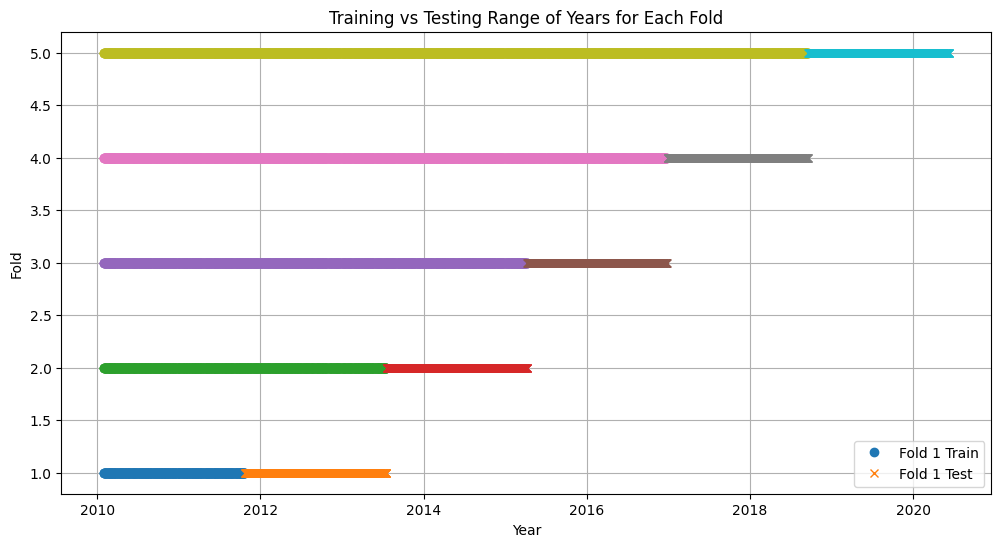

In [15]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Model training and evaluation



Fold 1 Confusion Matrix:
[[140  54]
 [ 18 222]]


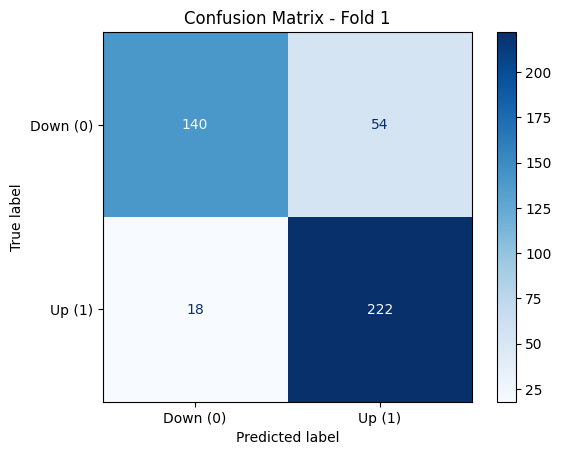

Fold 1 Accuracy: 0.83
--------------------------------------------------

Fold 2 Confusion Matrix:
[[178  27]
 [ 45 184]]


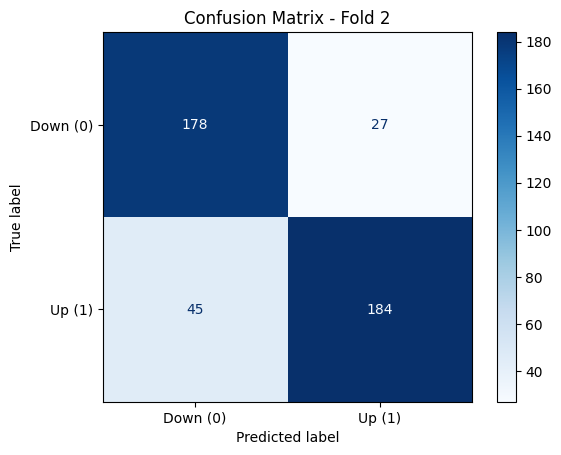

Fold 2 Accuracy: 0.83
--------------------------------------------------

Fold 3 Confusion Matrix:
[[179  38]
 [ 26 191]]


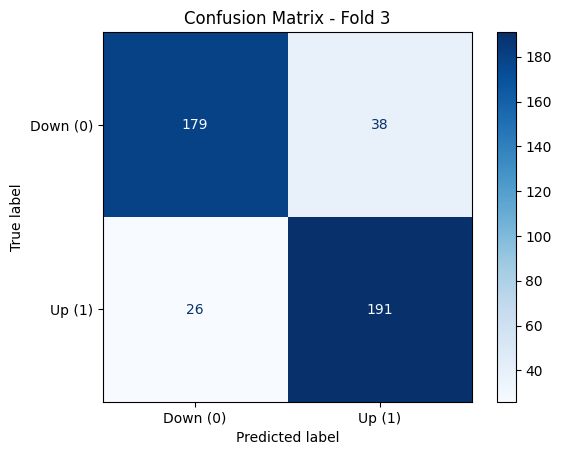

Fold 3 Accuracy: 0.85
--------------------------------------------------

Fold 4 Confusion Matrix:
[[189   7]
 [ 60 178]]


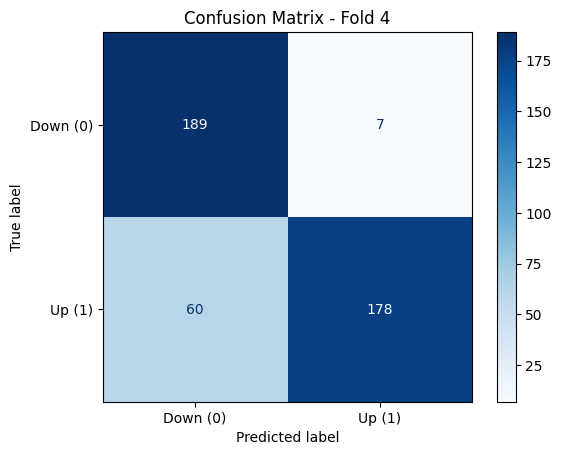

Fold 4 Accuracy: 0.85
--------------------------------------------------

Fold 5 Confusion Matrix:
[[165  51]
 [ 13 205]]


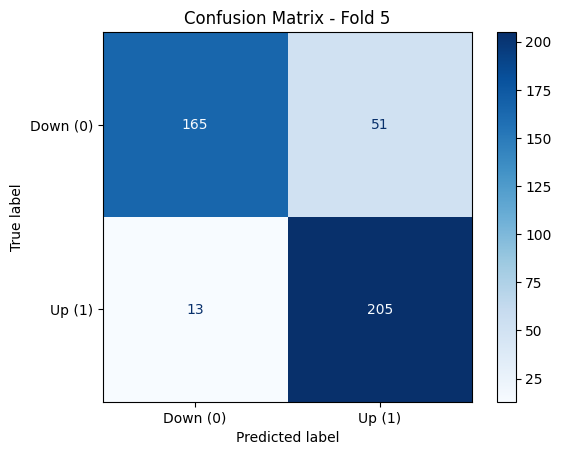

Fold 5 Accuracy: 0.85
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.84
Precision: 0.85
Recall: 0.86
F1-Score: 0.85
ROC-AUC: 0.94


In [16]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()
    
    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


# Evaluation on balanced data

Fold 1 - Balanced Class Distribution:
Movement
0    217
1    217
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[130  64]
 [ 16 224]]


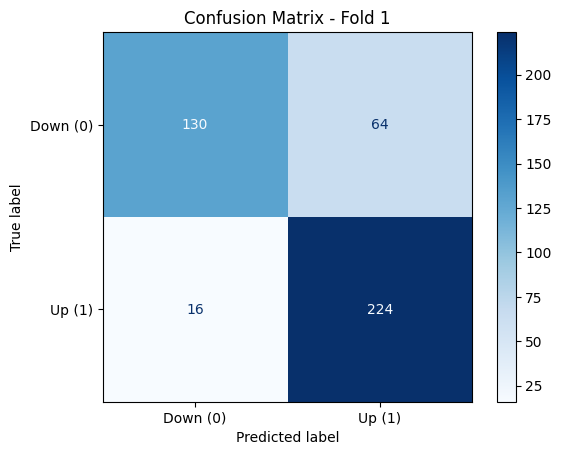

Fold 1 Accuracy: 0.82
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    416
1    416
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[194  11]
 [ 71 158]]


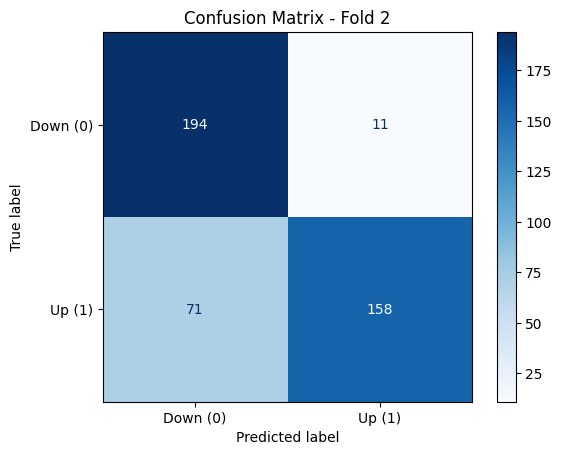

Fold 2 Accuracy: 0.81
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    621
1    621
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[202  15]
 [ 41 176]]


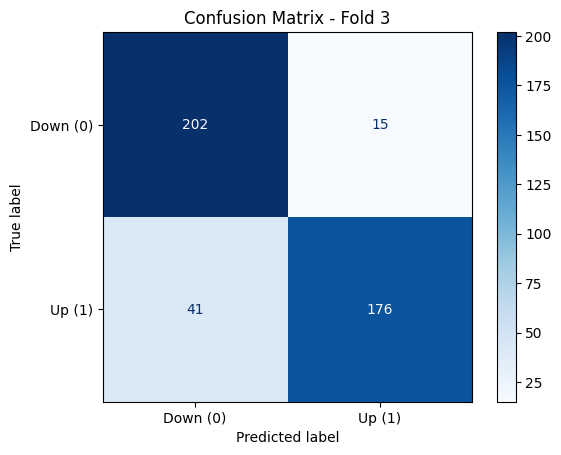

Fold 3 Accuracy: 0.87
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    838
1    838
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[193   3]
 [ 77 161]]


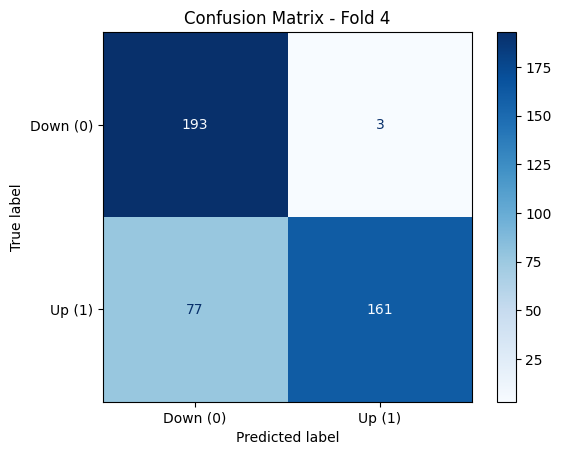

Fold 4 Accuracy: 0.82
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    1034
1    1034
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[186  30]
 [ 20 198]]


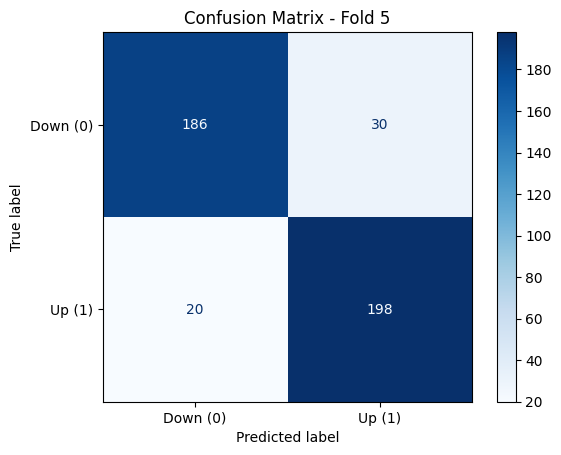

Fold 5 Accuracy: 0.88
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.84
Precision: 0.90
Recall: 0.80
F1-Score: 0.84
ROC-AUC: 0.94


In [17]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)
    
    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


In [18]:
data.to_csv('../../../dataset_final/Daily_Financial_News/MS/MS_numerical_LR.csv')